# Tutorial in Bayesian Optimization

#### Javier Gonzalez (j.h.gonzalez@sheffield.ac.uk)  University of Sheffield.

## The basics

Bayesian optimization (BO) is an strategy for global optimization of black-box functions. For instance, consider a Lipschitz continuous function $f(x)$ defined on a domain $\mathcal{X}$. BO aims to obtain

$$x^* = \arg \max_{\mathcal{X}} f(x)$$

There are two crucial bits in any Bayesian Optimization (BO) procedure approach.

* Define a **prior probability measure** on $f$: this function will capture the our prior beliefs on $f$. The prior will be updated to a 'posterior' using the available data.

* Define an **acquisition function** $acqu(x)$: this is a criteria to decide where to sample next in order to gain the maximum information about the location of the global maximum of $f$.

Given a prior over the function $f$ and an acquisition function a BO procedure will converge to the optimum of $f$ under some conditions.

## Use of Bayesian Optimization in real applications

BO has been applied to solve a wide range of problems such us: Interactive animation, Sensor networks,
Automatic algorithm configuration, Automatic machine learning toolboxes, Reinforcement learning,  Organization planning, Deep learning, Engineering and a long etc!

## 1D-Toy illustration

We illustrate the idea behind BO using a one-dimensional example. We start by importing the required libraries for the analysis. Note that we use our library GPy for Gaussian Processes! The on-line documentation of GPy is available from the [SheffieldML github page](https://github.com/SheffieldML/GPy).

In [1]:
%matplotlib inline  
import GPy     
import pylab as pb
import numpy as np
import matplotlib.pyplot as plt  # plots
import scipy.stats
from scipy.stats import norm

Let's start by considering the function $f(x) = − \cos(2πx ) + \sin(4\pi x )$ defined on the interval $[0.08, 0.92]$. The maximum of this function is located at $x_{max}=0.6010$. Obviously, to obtain it in this example is trivial. But, what if $f$ is not explicitly available and we only have access to a small number of noise evaluations? We see how the BO acts in this case for illustrative purpose but, of course, BO can be used in more complex scenarios. We first generate 3 noisy observations sampled from $f$ and we proceed.

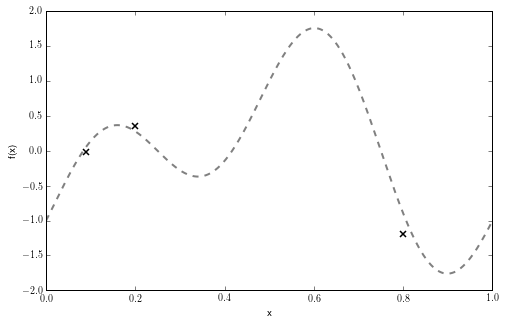

In [2]:
## Function f(x)
X_star = np.linspace(0,1,1000)[:,None]
Y_star = -np.cos(2*np.pi*X_star) + np.sin(4*np.pi*X_star)
X_eval = X_star

# Sampled values
np.random.seed([1])
n = 3
X = np.array([[0.09],[0.2],[0.8]])
Y = -np.cos(2*np.pi*X) + np.sin(4*np.pi*X) + np.random.randn(n,1)*0.1

# Plot of f(x) and the generated sample
plt.rcParams['figure.figsize'] = 8, 5 
plt.figure();
plt.plot(X_star,Y_star,c='grey',lw=2,ls='--',mew=1.5)
plt.plot(X,Y,'kx',mew=1.5)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.savefig('data.pdf')

### 3.1 Gaussian Process Prior

Now we define a Gaussian Process (GP) prior on $f$. A GP is an extension of the multivariate Gaussian distribution to an infinite dimension stochastic process for which any finite combination of dimensions is a Gaussian distribution. Therefore a GP is a distribution over functions, which is totally specified by its mean function $m(x)$ and its covariance function $k(x,x')$:

$$f(x) \sim \mathcal{GP}(m(x),k(x,x')) $$

For convenience, the mean is often fixed as $m(x)=0$. We use as covariance function the exponentiated quadratic kernel

$$ k(x,x') = l \cdot exp{ \left(\frac{\|x-x'\|}{2\sigma^2}\right)} $$
where $\sigma^2$ and and $l$ are positive parameters. Next, we fit this model in our dataset. We start by a kernel object.

In [3]:
# Choose the kernel
k = GPy.kern.RBF(input_dim=1, variance=1, lengthscale=0.1)

Now we create a Gaussian Process model using as covariance function the the previous kernel and we optimize the parameters by maximizing the log-likelihood. Ir order to avoid local solutions we use 10 different initial points in the optimization process.

In [4]:
# We create the GP model
m = GPy.models.GPRegression(X, Y, k)
m.optimize()
m.optimize_restarts(num_restarts = 10)

Optimization restart 1/10, f = 2.98700489767
Optimization restart 2/10, f = 3.28304125657
Optimization restart 3/10, f = 3.28304173249
Optimization restart 4/10, f = 2.98700487589
Optimization restart 5/10, f = 2.98700492174
Optimization restart 6/10, f = 2.98700488549
Optimization restart 7/10, f = 2.98700487742
Optimization restart 8/10, f = 2.98700487575
Optimization restart 9/10, f = 3.28304149527
Optimization restart 10/10, f = 3.28304124591


Now, it is time to have a look to the fitted model. We show the parameters and the fitted function and a plot to see how it fit the data.


Name : GP regression
Objective : 2.98700487575
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |              value  |  constraints  |  priors
  rbf.variance             |     0.655167167518  |      +ve      |        
  rbf.lengthscale          |     0.191682159649  |      +ve      |        
  Gaussian_noise.variance  |  6.74045548918e-09  |      +ve      |        


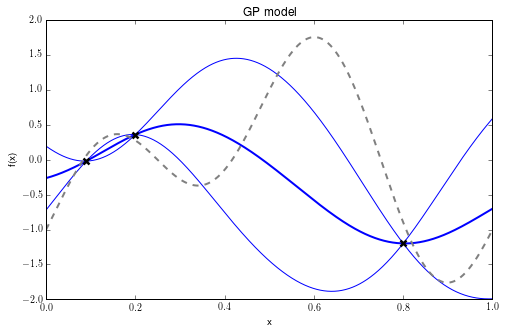

In [5]:
print m
#m.plot()
fest = m.predict(X_star)
plt.plot(X_star,fest[0],c='blue',lw=2,ls='-',mew=1.5)
plt.plot(X_star,fest[0]+1.96*np.sqrt(fest[1]),c='blue',lw=1,ls='-',mew=1)
plt.plot(X_star,fest[0]-1.96*np.sqrt(fest[1]),c='blue',lw=1,ls='-',mew=1)
plt.plot(X,Y,'kx',mew=2.5)
plt.plot(X_star,Y_star,c='grey',lw=2,ls='--',mew=1.5)
plt.title('GP model')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.xlim(0,1)
plt.savefig('datamodel.pdf')

Given this model, where do you think the maximum of the function should be? Around 0.3 the posterior mean is maximum but around 0.45 the variance is large. If you could collect a new data point, where would you do it? This is the job of the second main element of any Bayesian Optimization procedure: the acquisition function.

### 3.2 Aquisition functions

Next lines of code define the three acquisition functions we are going to use in our example. They are the functions that represents our beliefs over the maximum of $f(x)$. Denote by $\theta$ the parameters of the GP model and by $\{x_i,y_i\}$ the available sample. Three of the most common acquisition functions are:

* **Maximum probability of improvement (MPI)**:

$$acqu_{MPI}(x;\{x_n,y_n\},\theta) = \Phi(\gamma(x)), \mbox{where}\   \gamma(x)=\frac{\mu(x;\{x_n,y_n\},\theta)-f(x_{best})-\psi}{\sigma(x;\{x_n,y_n\},\theta)}.$$


* **Expected improvement (EI)**:

$$acqu_{EI}(x;\{x_n,y_n\},\theta) = \sigma(x;\{x_n,y_n\},\theta) (\gamma(x) \Phi(\gamma(x))) + N(\gamma(x);0,1).$$

* **Upper confidence bound (UCB)**:

$$acqu_{UCB}(x;\{x_n,y_n\},\theta) = \mu(x;\{x_n,y_n\},\theta)+\eta\sigma(x;\{x_n,y_n\},\theta).$$

Both, $\psi$ and $\eta$, are tunable parameters that help to make the acquisition functions more flexible. Also, in the case of the UBC, the parameter $\eta$ is useful to define the balance between the importance we give to the mean and the variance of the model. This is know as the **exploration/exploitation trade off**.

In [6]:
def MPI_max(x,model,par = 0.01):
 fest = model.predict(x)
 acqu = norm.cdf((fest[0]-max(fest[0])-par) / fest[1])
 return acqu

def EI_max(x,model,par = 0.01):
 fest = model.predict(x)
 Z = (fest[0]-max(fest[0])-par) / fest[1]
 acqu = (fest[0]-max(fest[0])-par)*norm.cdf(Z)+fest[1]*norm.pdf(Z)
 return acqu

def UBC_max(x,model,z_mui=1):
 fest = model.predict(x)
 acqu = fest[0]+z_mui*np.sqrt(fest[1])
 return acqu

We evaluate the functions on our interval of interest. Here, the maximum is found using grid search but in higher dimensional problems and the maximum can be systematically obtained with a Conjugate Gradient method.

In [7]:
## Evaluate and get the maximum of the acquisition function (grid seach for-plotting purposes)
# MPI
acqu_MPI1 = MPI_max(X_eval,m,0.01) 
acqu_MPI2 = MPI_max(X_eval,m,0.1) 
acqu_MPI3 = MPI_max(X_eval,m,0.5) 
max_MPI1 = X_eval[np.argmax(acqu_MPI1)]
max_MPI2 = X_eval[np.argmax(acqu_MPI2)]
max_MPI3 = X_eval[np.argmax(acqu_MPI3)]

# EI
acqu_EI1  = EI_max(X_eval,m,0.01)
acqu_EI2  = EI_max(X_eval,m,0.1)
acqu_EI3  = EI_max(X_eval,m,0.5)
max_EI1 = X_eval[np.argmax(acqu_EI1)]
max_EI2 = X_eval[np.argmax(acqu_EI2)]
max_EI3 = X_eval[np.argmax(acqu_EI3)]
res_max_EI3 = max_EI3

# UBC
acqu_UBC1 = UBC_max(X_eval,m,0.5)   
acqu_UBC2 = UBC_max(X_eval,m,1)
acqu_UBC3 = UBC_max(X_eval,m,4)
max_UBC1 = X_eval[np.argmax(acqu_UBC1)]
max_UBC2 = X_eval[np.argmax(acqu_UBC2)]
max_UBC3 = X_eval[np.argmax(acqu_UBC3)]
res_max_UBC3 = max_UBC3

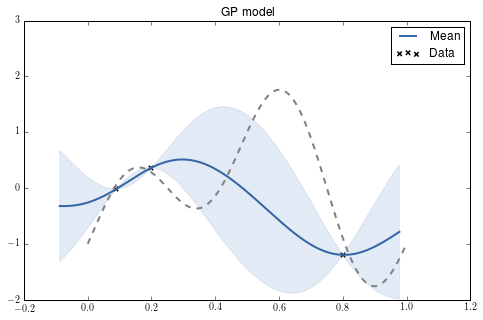

In [8]:
# Plot GP posterior, collected data and the acquisition function
m.plot()
plt.ylim(-2,3)
plt.plot(X_star,Y_star,c='grey',lw=2,ls='--',mew=1.5)
plt.title('GP model')
plt.savefig('datamodel.pdf')

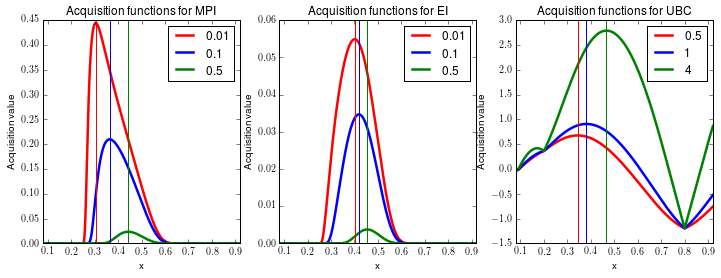

In [9]:
plt.figure(figsize=(12,4))
plt.subplot(1, 3, 1)
plt.title('Acquisition functions for MPI')
plt.xlim(0.08,0.92)
p1, = plt.plot(X_eval, acqu_MPI1, 'r-',lw=2.5)
p2, = plt.plot(X_eval, acqu_MPI2, 'b-',lw=2.5)
p3, = plt.plot(X_eval, acqu_MPI3, 'g-',lw=2.5)
plt.title('Acquisition functions for MPI')
plt.xlim(0.08,0.92)
plt.xlabel('x')
plt.ylabel('Acquisition value')
plt.legend([p1, p2, p3], ["0.01", "0.1", "0.5"])
plt.axvline(x=max_MPI1,ls='-',c='red')
plt.axvline(x=max_MPI2,ls='-',c='blue')
plt.axvline(x=max_MPI3,ls='-',c='green')

plt.subplot(1, 3, 2)
plt.plot(X_eval, acqu_EI1, 'r-',lw=2.5)
plt.plot(X_eval, acqu_EI2, 'b-',lw=2.5)
plt.plot(X_eval, acqu_EI3, 'g-',lw=2.5)
plt.title('Acquisition functions for EI')
plt.xlim(0.08,0.92)
plt.xlabel('x')
plt.ylabel('Acquisition value')
plt.legend([p1, p2, p3], ["0.01", "0.1", "0.5"])
plt.axvline(x=max_EI1,ls='-',c='red')
plt.axvline(x=max_EI2,ls='-',c='blue')
plt.axvline(x=max_EI3,ls='-',c='green')

plt.subplot(1, 3, 3)
p1, = plt.plot(X_eval, acqu_UBC1, 'r-',lw=2.5)
p2, = plt.plot(X_eval, acqu_UBC2, 'b-',lw=2.5)
p3, = plt.plot(X_eval, acqu_UBC3, 'g-',lw=2.5)
plt.title('Acquisition functions for UBC')
plt.xlim(0.08,0.92)
plt.xlabel('x')
plt.ylabel('Acquisition value')
plt.legend([p1, p2, p3], ["0.5", "1", "4"])
plt.axvline(x=max_UBC1,ls='-',c='red')
plt.axvline(x=max_UBC2,ls='-',c='blue')
plt.axvline(x=max_UBC3,ls='-',c='green')

Next, we show the how the three functions represents our beliefs about the maximum of $f(x)$. Note that all of them use the **mean** and the **variance** of the Gaussian process we have fitted to the data. In this example we simply select some values of the parameters.

You can see how the thee acquisition functions represent their beliefs about the maximum of $f(x)$ in a different way. It is up to the user to select the most appropriate depending on the problem. Typically, if we can collect new data we will do it in the maximum of the acquisition function.

### 3.3 Iterative sampling/sequential design

Next, to see how BO works iteratively, we use the Expected improvement with $\psi=0.5$. In each iteration we use the same generative model we considered for our first three data points in the point where $acqu_{EI}(x)$ is maximum. See what happens by running several times the cell below!!

Optimization restart 1/10, f = 3.49848851872
Optimization restart 2/10, f = 3.4984885187
Optimization restart 3/10, f = 3.4984885187
Optimization restart 4/10, f = 3.49848851869
Optimization restart 5/10, f = 3.4984885187
Optimization restart 6/10, f = 3.49848851869
Optimization restart 7/10, f = 3.4984885187
Optimization restart 8/10, f = 3.49848851869
Optimization restart 9/10, f = 4.00158308045
Optimization restart 10/10, f = 3.49848851872


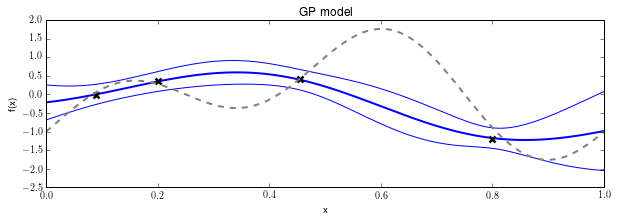

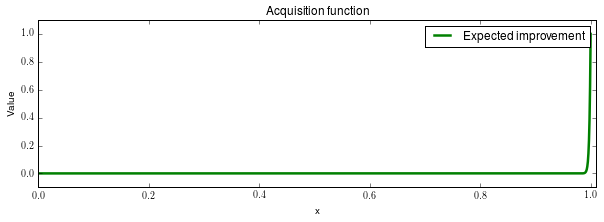

In [10]:
# 1.- Collect an new sample where the MPI indicates and attach to the previous dataset
x_new = max_EI3
y_new = -np.cos(2*np.pi*x_new) + np.sin(4*np.pi*x_new) + np.random.randn(1,1)*0.1
X = np.vstack([X,x_new])
Y = np.vstack([Y,y_new])

# 2.- Run and optimize the new GP model
k = GPy.kern.RBF(input_dim=1, variance=.1, lengthscale=.1)
m_augmented = GPy.models.GPRegression(X, Y, k)
m_augmented.constrain_positive('')
m_augmented.likelihood.fix(0.01)
m_augmented.optimize_restarts(num_restarts = 10, messages=0)

# 3.- Optimize aquisition function MPI
acqu_EI3 = EI_max(X_eval,m_augmented,0.5) 
max_EI3 = X_eval[np.argmax(acqu_EI3)]
res_max_EI3 = np.vstack([res_max_EI3,max_EI3])
x_res = np.linspace(1,res_max_EI3.shape[0],res_max_EI3.shape[0])

# GP plot
plt.rcParams['figure.figsize'] = 10, 3 
# GP plot
fest = m_augmented.predict(X_star)
plt.plot(X_star,fest[0],c='blue',lw=2,ls='-',mew=4)
plt.plot(X_star,fest[0]+1.96*np.sqrt(fest[1]),c='blue',lw=1,ls='-',mew=1)
plt.plot(X_star,fest[0]-1.96*np.sqrt(fest[1]),c='blue',lw=1,ls='-',mew=1)
plt.plot(X,Y,'kx',mew=2.5)
plt.title('GP model')
plt.xlabel('x')
plt.plot(X_star,Y_star,c='grey',lw=2,ls='--',mew=1.5)
plt.ylabel('f(x)')
plt.xlim(0,1)
plt.savefig('datamodel7.pdf')
# EI plot
plt.rcParams['figure.figsize'] = 10, 3 
plt.figure(figsize=(10,3))
p1, = plt.plot(X_eval,(acqu_EI3-min(acqu_EI3))/(max(acqu_EI3-min(acqu_EI3)) or 1.), 'g-',lw=2.5)
plt.title('Acquisition function')
plt.xlim(0,1.01)
plt.ylim(-0.1,1.1)
plt.xlabel('x')
plt.ylabel('Value')
plt.legend([p1], ["Expected improvement"])
plt.savefig('aq7.pdf')

#print m_augmented
# Convergence plot
#plt.subplot(1, 2, 2)
#plt.plot(x_res,res_max_EI3,'kx',mew=4.5)
#plt.title('Convergence to the maximum')
#plt.xlabel('iteration')
#plt.ylabel('Value')
#plt.ylim(-0.25,1.5)
#plt.plot(x_res,res_max_EI3,'g-',lw=2.5)
#axhline(y=0.6010,ls='--',c='red'#)

Optimization restart 1/10, f = 3.75093360803
Optimization restart 2/10, f = 3.75093360803
Optimization restart 3/10, f = 3.75093360803
Optimization restart 4/10, f = 5.49714812342
Optimization restart 5/10, f = 3.75093360803
Optimization restart 6/10, f = 3.75093360803
Optimization restart 7/10, f = 3.75093360804
Optimization restart 8/10, f = 5.49714812342
Optimization restart 9/10, f = 3.75093360803
Optimization restart 10/10, f = 5.49715359163


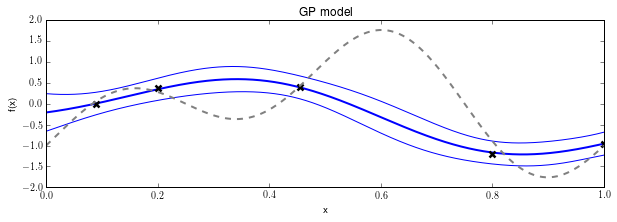

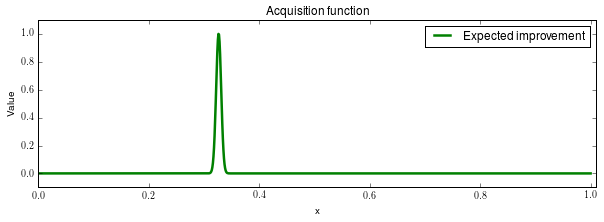

In [11]:
# 1.- Collect an new sample where the MPI indicates and attach to the previous dataset
x_new = max_EI3
y_new = -np.cos(2*np.pi*x_new) + np.sin(4*np.pi*x_new) + np.random.randn(1,1)*0.1
X = np.vstack([X,x_new])
Y = np.vstack([Y,y_new])

# 2.- Run and optimize the new GP model
k = GPy.kern.RBF(input_dim=1, variance=.1, lengthscale=.1)
m_augmented = GPy.models.GPRegression(X, Y, k)
m_augmented.constrain_positive('')
m_augmented.likelihood.fix(0.01)
m_augmented.optimize_restarts(num_restarts = 10, messages=0)

# 3.- Optimize aquisition function MPI
acqu_EI3 = EI_max(X_eval,m_augmented,0.5) 
max_EI3 = X_eval[np.argmax(acqu_EI3)]
res_max_EI3 = np.vstack([res_max_EI3,max_EI3])
x_res = np.linspace(1,res_max_EI3.shape[0],res_max_EI3.shape[0])

# GP plot
plt.rcParams['figure.figsize'] = 10, 3 
# GP plot
fest = m_augmented.predict(X_star)
plt.plot(X_star,fest[0],c='blue',lw=2,ls='-',mew=4)
plt.plot(X_star,fest[0]+1.96*np.sqrt(fest[1]),c='blue',lw=1,ls='-',mew=1)
plt.plot(X_star,fest[0]-1.96*np.sqrt(fest[1]),c='blue',lw=1,ls='-',mew=1)
plt.plot(X,Y,'kx',mew=2.5)
plt.title('GP model')
plt.xlabel('x')
plt.plot(X_star,Y_star,c='grey',lw=2,ls='--',mew=1.5)
plt.ylabel('f(x)')
plt.xlim(0,1)
plt.savefig('datamodel7.pdf')
# EI plot
plt.rcParams['figure.figsize'] = 10, 3 
plt.figure(figsize=(10,3))
p1, = plt.plot(X_eval,(acqu_EI3-min(acqu_EI3))/(max(acqu_EI3-min(acqu_EI3)) or 1.), 'g-',lw=2.5)
plt.title('Acquisition function')
plt.xlim(0,1.01)
plt.ylim(-0.1,1.1)
plt.xlabel('x')
plt.ylabel('Value')
plt.legend([p1], ["Expected improvement"])
plt.savefig('aq7.pdf')

#print m_augmented
# Convergence plot
#plt.subplot(1, 2, 2)
#plt.plot(x_res,res_max_EI3,'kx',mew=4.5)
#plt.title('Convergence to the maximum')
#plt.xlabel('iteration')
#plt.ylabel('Value')
#plt.ylim(-0.25,1.5)
#plt.plot(x_res,res_max_EI3,'g-',lw=2.5)
#axhline(y=0.6010,ls='--',c='red'#)

Optimization restart 1/10, f = 6.16520267201
Optimization restart 2/10, f = 6.16520232015
Optimization restart 3/10, f = 6.16520230571
Optimization restart 4/10, f = 6.16520230571
Optimization restart 5/10, f = 6.16520232138
Optimization restart 6/10, f = 6.19056540555
Optimization restart 7/10, f = 6.16520232051
Optimization restart 8/10, f = 6.19056540555
Optimization restart 9/10, f = 6.16520236315
Optimization restart 10/10, f = 6.16520231321


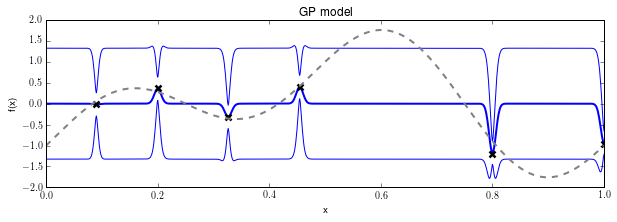

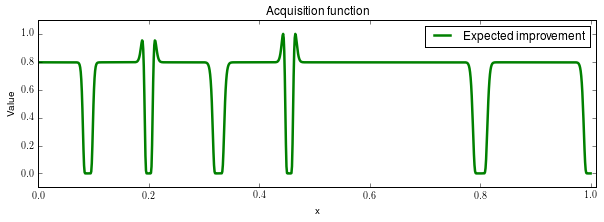

In [12]:
# 1.- Collect an new sample where the MPI indicates and attach to the previous dataset
x_new = max_EI3
y_new = -np.cos(2*np.pi*x_new) + np.sin(4*np.pi*x_new) + np.random.randn(1,1)*0.1
X = np.vstack([X,x_new])
Y = np.vstack([Y,y_new])

# 2.- Run and optimize the new GP model
k = GPy.kern.RBF(input_dim=1, variance=.1, lengthscale=.1)
m_augmented = GPy.models.GPRegression(X, Y, k)
m_augmented.constrain_positive('')
m_augmented.likelihood.fix(0.01)
m_augmented.optimize_restarts(num_restarts = 10, messages=0)

# 3.- Optimize aquisition function MPI
acqu_EI3 = EI_max(X_eval,m_augmented,0.5) 
max_EI3 = X_eval[np.argmax(acqu_EI3)]
res_max_EI3 = np.vstack([res_max_EI3,max_EI3])
x_res = np.linspace(1,res_max_EI3.shape[0],res_max_EI3.shape[0])

# GP plot
plt.rcParams['figure.figsize'] = 10, 3 
# GP plot
fest = m_augmented.predict(X_star)
plt.plot(X_star,fest[0],c='blue',lw=2,ls='-',mew=4)
plt.plot(X_star,fest[0]+1.96*np.sqrt(fest[1]),c='blue',lw=1,ls='-',mew=1)
plt.plot(X_star,fest[0]-1.96*np.sqrt(fest[1]),c='blue',lw=1,ls='-',mew=1)
plt.plot(X,Y,'kx',mew=2.5)
plt.title('GP model')
plt.xlabel('x')
plt.plot(X_star,Y_star,c='grey',lw=2,ls='--',mew=1.5)
plt.ylabel('f(x)')
plt.xlim(0,1)
plt.savefig('datamodel7.pdf')
# EI plot
plt.rcParams['figure.figsize'] = 10, 3 
plt.figure(figsize=(10,3))
p1, = plt.plot(X_eval,(acqu_EI3-min(acqu_EI3))/(max(acqu_EI3-min(acqu_EI3)) or 1.), 'g-',lw=2.5)
plt.title('Acquisition function')
plt.xlim(0,1.01)
plt.ylim(-0.1,1.1)
plt.xlabel('x')
plt.ylabel('Value')
plt.legend([p1], ["Expected improvement"])
plt.savefig('aq7.pdf')

#print m_augmented
# Convergence plot
#plt.subplot(1, 2, 2)
#plt.plot(x_res,res_max_EI3,'kx',mew=4.5)
#plt.title('Convergence to the maximum')
#plt.xlabel('iteration')
#plt.ylabel('Value')
#plt.ylim(-0.25,1.5)
#plt.plot(x_res,res_max_EI3,'g-',lw=2.5)
#axhline(y=0.6010,ls='--',c='red'#)

Optimization restart 1/10, f = 5.70559340355
Optimization restart 2/10, f = 5.70559340351
Optimization restart 3/10, f = 5.70559340351
Optimization restart 4/10, f = 5.70559340351
Optimization restart 5/10, f = 5.70559340351
Optimization restart 6/10, f = 5.70559340351
Optimization restart 7/10, f = 5.70559340351
Optimization restart 8/10, f = 5.70559340351
Optimization restart 9/10, f = 5.70559340351
Optimization restart 10/10, f = 5.70559340351


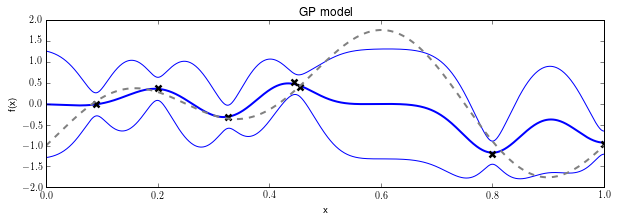

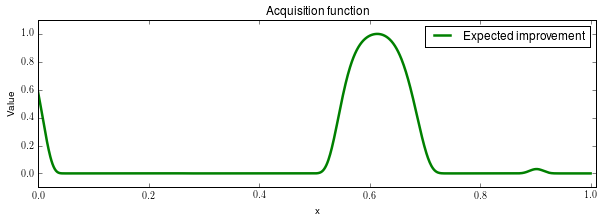

In [13]:
# 1.- Collect an new sample where the MPI indicates and attach to the previous dataset
x_new = max_EI3
y_new = -np.cos(2*np.pi*x_new) + np.sin(4*np.pi*x_new) + np.random.randn(1,1)*0.1
X = np.vstack([X,x_new])
Y = np.vstack([Y,y_new])

# 2.- Run and optimize the new GP model
k = GPy.kern.RBF(input_dim=1, variance=.1, lengthscale=.1)
m_augmented = GPy.models.GPRegression(X, Y, k)
m_augmented.constrain_positive('')
m_augmented.likelihood.fix(0.01)
m_augmented.optimize_restarts(num_restarts = 10, messages=0)

# 3.- Optimize aquisition function MPI
acqu_EI3 = EI_max(X_eval,m_augmented,0.5) 
max_EI3 = X_eval[np.argmax(acqu_EI3)]
res_max_EI3 = np.vstack([res_max_EI3,max_EI3])
x_res = np.linspace(1,res_max_EI3.shape[0],res_max_EI3.shape[0])

# GP plot
plt.rcParams['figure.figsize'] = 10, 3 
# GP plot
fest = m_augmented.predict(X_star)
plt.plot(X_star,fest[0],c='blue',lw=2,ls='-',mew=4)
plt.plot(X_star,fest[0]+1.96*np.sqrt(fest[1]),c='blue',lw=1,ls='-',mew=1)
plt.plot(X_star,fest[0]-1.96*np.sqrt(fest[1]),c='blue',lw=1,ls='-',mew=1)
plt.plot(X,Y,'kx',mew=2.5)
plt.title('GP model')
plt.xlabel('x')
plt.plot(X_star,Y_star,c='grey',lw=2,ls='--',mew=1.5)
plt.ylabel('f(x)')
plt.xlim(0,1)
plt.savefig('datamodel7.pdf')
# EI plot
plt.rcParams['figure.figsize'] = 10, 3 
plt.figure(figsize=(10,3))
p1, = plt.plot(X_eval,(acqu_EI3-min(acqu_EI3))/(max(acqu_EI3-min(acqu_EI3)) or 1.), 'g-',lw=2.5)
plt.title('Acquisition function')
plt.xlim(0,1.01)
plt.ylim(-0.1,1.1)
plt.xlabel('x')
plt.ylabel('Value')
plt.legend([p1], ["Expected improvement"])
plt.savefig('aq7.pdf')

#print m_augmented
# Convergence plot
#plt.subplot(1, 2, 2)
#plt.plot(x_res,res_max_EI3,'kx',mew=4.5)
#plt.title('Convergence to the maximum')
#plt.xlabel('iteration')
#plt.ylabel('Value')
#plt.ylim(-0.25,1.5)
#plt.plot(x_res,res_max_EI3,'g-',lw=2.5)
#axhline(y=0.6010,ls='--',c='red'#)

Optimization restart 1/10, f = 8.77664094635
Optimization restart 2/10, f = 8.77664094634
Optimization restart 3/10, f = 8.77664094802
Optimization restart 4/10, f = 8.77664094634
Optimization restart 5/10, f = 8.77664094634
Optimization restart 6/10, f = 8.77664094634
Optimization restart 7/10, f = 8.77664094634
Optimization restart 8/10, f = 8.77664094636
Optimization restart 9/10, f = 8.77664094635
Optimization restart 10/10, f = 8.77664094636


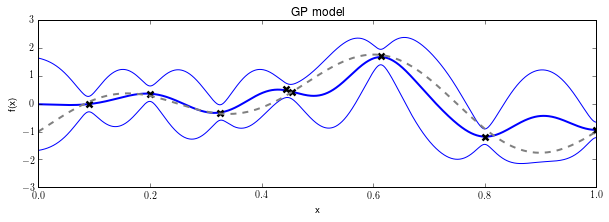

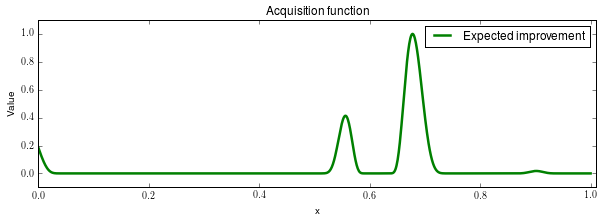

In [14]:
# 1.- Collect an new sample where the MPI indicates and attach to the previous dataset
x_new = max_EI3
y_new = -np.cos(2*np.pi*x_new) + np.sin(4*np.pi*x_new) + np.random.randn(1,1)*0.1
X = np.vstack([X,x_new])
Y = np.vstack([Y,y_new])

# 2.- Run and optimize the new GP model
k = GPy.kern.RBF(input_dim=1, variance=.1, lengthscale=.1)
m_augmented = GPy.models.GPRegression(X, Y, k)
m_augmented.constrain_positive('')
m_augmented.likelihood.fix(0.01)
m_augmented.optimize_restarts(num_restarts = 10, messages=0)

# 3.- Optimize aquisition function MPI
acqu_EI3 = EI_max(X_eval,m_augmented,0.5) 
max_EI3 = X_eval[np.argmax(acqu_EI3)]
res_max_EI3 = np.vstack([res_max_EI3,max_EI3])
x_res = np.linspace(1,res_max_EI3.shape[0],res_max_EI3.shape[0])

# GP plot
plt.rcParams['figure.figsize'] = 10, 3 
# GP plot
fest = m_augmented.predict(X_star)
plt.plot(X_star,fest[0],c='blue',lw=2,ls='-',mew=4)
plt.plot(X_star,fest[0]+1.96*np.sqrt(fest[1]),c='blue',lw=1,ls='-',mew=1)
plt.plot(X_star,fest[0]-1.96*np.sqrt(fest[1]),c='blue',lw=1,ls='-',mew=1)
plt.plot(X,Y,'kx',mew=2.5)
plt.title('GP model')
plt.xlabel('x')
plt.plot(X_star,Y_star,c='grey',lw=2,ls='--',mew=1.5)
plt.ylabel('f(x)')
plt.xlim(0,1)
plt.savefig('datamodel7.pdf')
# EI plot
plt.rcParams['figure.figsize'] = 10, 3 
plt.figure(figsize=(10,3))
p1, = plt.plot(X_eval,(acqu_EI3-min(acqu_EI3))/(max(acqu_EI3-min(acqu_EI3)) or 1.), 'g-',lw=2.5)
plt.title('Acquisition function')
plt.xlim(0,1.01)
plt.ylim(-0.1,1.1)
plt.xlabel('x')
plt.ylabel('Value')
plt.legend([p1], ["Expected improvement"])
plt.savefig('aq7.pdf')

#print m_augmented
# Convergence plot
#plt.subplot(1, 2, 2)
#plt.plot(x_res,res_max_EI3,'kx',mew=4.5)
#plt.title('Convergence to the maximum')
#plt.xlabel('iteration')
#plt.ylabel('Value')
#plt.ylim(-0.25,1.5)
#plt.plot(x_res,res_max_EI3,'g-',lw=2.5)
#axhline(y=0.6010,ls='--',c='red'#)

Optimization restart 1/10, f = 9.68268944351
Optimization restart 2/10, f = 9.68268944353
Optimization restart 3/10, f = 9.68268944353
Optimization restart 4/10, f = 9.68268944351
Optimization restart 5/10, f = 9.68268944352
Optimization restart 6/10, f = 9.68268944351
Optimization restart 7/10, f = 9.68268944352
Optimization restart 8/10, f = 9.68268944357
Optimization restart 9/10, f = 9.68268944351
Optimization restart 10/10, f = 9.68268944351


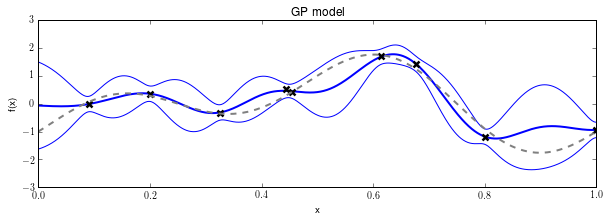

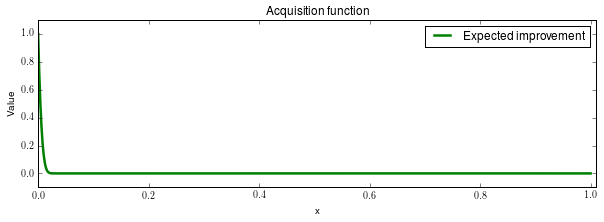

In [15]:
# 1.- Collect an new sample where the MPI indicates and attach to the previous dataset
x_new = max_EI3
y_new = -np.cos(2*np.pi*x_new) + np.sin(4*np.pi*x_new) + np.random.randn(1,1)*0.1
X = np.vstack([X,x_new])
Y = np.vstack([Y,y_new])

# 2.- Run and optimize the new GP model
k = GPy.kern.RBF(input_dim=1, variance=.1, lengthscale=.1)
m_augmented = GPy.models.GPRegression(X, Y, k)
m_augmented.constrain_positive('')
m_augmented.likelihood.fix(0.01)
m_augmented.optimize_restarts(num_restarts = 10, messages=0)

# 3.- Optimize aquisition function MPI
acqu_EI3 = EI_max(X_eval,m_augmented,0.5) 
max_EI3 = X_eval[np.argmax(acqu_EI3)]
res_max_EI3 = np.vstack([res_max_EI3,max_EI3])
x_res = np.linspace(1,res_max_EI3.shape[0],res_max_EI3.shape[0])

# GP plot
plt.rcParams['figure.figsize'] = 10, 3 
# GP plot
fest = m_augmented.predict(X_star)
plt.plot(X_star,fest[0],c='blue',lw=2,ls='-',mew=4)
plt.plot(X_star,fest[0]+1.96*np.sqrt(fest[1]),c='blue',lw=1,ls='-',mew=1)
plt.plot(X_star,fest[0]-1.96*np.sqrt(fest[1]),c='blue',lw=1,ls='-',mew=1)
plt.plot(X,Y,'kx',mew=2.5)
plt.title('GP model')
plt.xlabel('x')
plt.plot(X_star,Y_star,c='grey',lw=2,ls='--',mew=1.5)
plt.ylabel('f(x)')
plt.xlim(0,1)
plt.savefig('datamodel7.pdf')
# EI plot
plt.rcParams['figure.figsize'] = 10, 3 
plt.figure(figsize=(10,3))
p1, = plt.plot(X_eval,(acqu_EI3-min(acqu_EI3))/(max(acqu_EI3-min(acqu_EI3)) or 1.), 'g-',lw=2.5)
plt.title('Acquisition function')
plt.xlim(0,1.01)
plt.ylim(-0.1,1.1)
plt.xlabel('x')
plt.ylabel('Value')
plt.legend([p1], ["Expected improvement"])
plt.savefig('aq7.pdf')

#print m_augmented
# Convergence plot
#plt.subplot(1, 2, 2)
#plt.plot(x_res,res_max_EI3,'kx',mew=4.5)
#plt.title('Convergence to the maximum')
#plt.xlabel('iteration')
#plt.ylabel('Value')
#plt.ylim(-0.25,1.5)
#plt.plot(x_res,res_max_EI3,'g-',lw=2.5)
#axhline(y=0.6010,ls='--',c='red'#)

Optimization restart 1/10, f = 11.00359161
Optimization restart 2/10, f = 11.00359161
Optimization restart 3/10, f = 11.0035916103
Optimization restart 4/10, f = 11.00359161
Optimization restart 5/10, f = 13.5915481572
Optimization restart 6/10, f = 11.00359161
Optimization restart 7/10, f = 11.00359161
Optimization restart 8/10, f = 11.00359161
Optimization restart 9/10, f = 11.00359161
Optimization restart 10/10, f = 13.5915481572


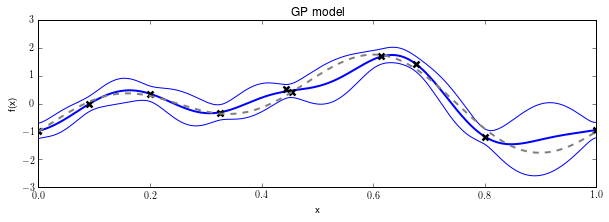

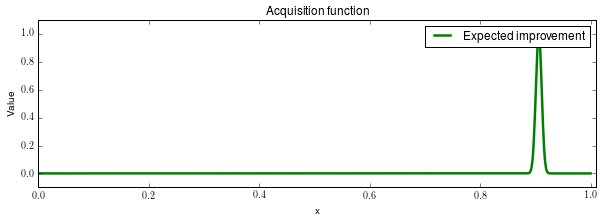

In [16]:
# 1.- Collect an new sample where the MPI indicates and attach to the previous dataset
x_new = max_EI3
y_new = -np.cos(2*np.pi*x_new) + np.sin(4*np.pi*x_new) + np.random.randn(1,1)*0.1
X = np.vstack([X,x_new])
Y = np.vstack([Y,y_new])

# 2.- Run and optimize the new GP model
k = GPy.kern.RBF(input_dim=1, variance=.1, lengthscale=.1)
m_augmented = GPy.models.GPRegression(X, Y, k)
m_augmented.constrain_positive('')
m_augmented.likelihood.fix(0.01)
m_augmented.optimize_restarts(num_restarts = 10, messages=0)

# 3.- Optimize aquisition function MPI
acqu_EI3 = EI_max(X_eval,m_augmented,0.5) 
max_EI3 = X_eval[np.argmax(acqu_EI3)]
res_max_EI3 = np.vstack([res_max_EI3,max_EI3])
x_res = np.linspace(1,res_max_EI3.shape[0],res_max_EI3.shape[0])

# GP plot
plt.rcParams['figure.figsize'] = 10, 3 
# GP plot
fest = m_augmented.predict(X_star)
plt.plot(X_star,fest[0],c='blue',lw=2,ls='-',mew=4)
plt.plot(X_star,fest[0]+1.96*np.sqrt(fest[1]),c='blue',lw=1,ls='-',mew=1)
plt.plot(X_star,fest[0]-1.96*np.sqrt(fest[1]),c='blue',lw=1,ls='-',mew=1)
plt.plot(X,Y,'kx',mew=2.5)
plt.title('GP model')
plt.xlabel('x')
plt.plot(X_star,Y_star,c='grey',lw=2,ls='--',mew=1.5)
plt.ylabel('f(x)')
plt.xlim(0,1)
plt.savefig('datamodel7.pdf')
# EI plot
plt.rcParams['figure.figsize'] = 10, 3 
plt.figure(figsize=(10,3))
p1, = plt.plot(X_eval,(acqu_EI3-min(acqu_EI3))/(max(acqu_EI3-min(acqu_EI3)) or 1.), 'g-',lw=2.5)
plt.title('Acquisition function')
plt.xlim(0,1.01)
plt.ylim(-0.1,1.1)
plt.xlabel('x')
plt.ylabel('Value')
plt.legend([p1], ["Expected improvement"])
plt.savefig('aq7.pdf')

#print m_augmented
# Convergence plot
#plt.subplot(1, 2, 2)
#plt.plot(x_res,res_max_EI3,'kx',mew=4.5)
#plt.title('Convergence to the maximum')
#plt.xlabel('iteration')
#plt.ylabel('Value')
#plt.ylim(-0.25,1.5)
#plt.plot(x_res,res_max_EI3,'g-',lw=2.5)
#axhline(y=0.6010,ls='--',c='red'#)

Optimization restart 1/10, f = 11.2518405535
Optimization restart 2/10, f = 11.2518405535
Optimization restart 3/10, f = 11.2518405535
Optimization restart 4/10, f = 11.2518405535
Optimization restart 5/10, f = 11.2518405535
Optimization restart 6/10, f = 11.2518405535
Optimization restart 7/10, f = 15.9894926032
Optimization restart 8/10, f = 11.2518405535
Optimization restart 9/10, f = 11.2518405535
Optimization restart 10/10, f = 11.2518405544


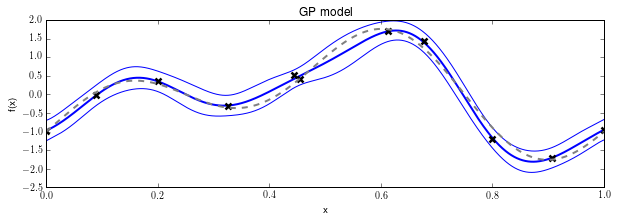

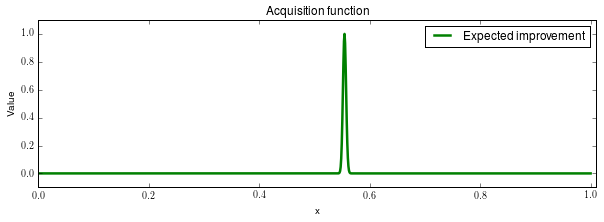

In [17]:
# 1.- Collect an new sample where the MPI indicates and attach to the previous dataset
x_new = max_EI3
y_new = -np.cos(2*np.pi*x_new) + np.sin(4*np.pi*x_new) + np.random.randn(1,1)*0.1
X = np.vstack([X,x_new])
Y = np.vstack([Y,y_new])

# 2.- Run and optimize the new GP model
k = GPy.kern.RBF(input_dim=1, variance=.1, lengthscale=.1)
m_augmented = GPy.models.GPRegression(X, Y, k)
m_augmented.constrain_positive('')
m_augmented.likelihood.fix(0.01)
m_augmented.optimize_restarts(num_restarts = 10, messages=0)

# 3.- Optimize aquisition function MPI
acqu_EI3 = EI_max(X_eval,m_augmented,0.5) 
max_EI3 = X_eval[np.argmax(acqu_EI3)]
res_max_EI3 = np.vstack([res_max_EI3,max_EI3])
x_res = np.linspace(1,res_max_EI3.shape[0],res_max_EI3.shape[0])

# GP plot
plt.rcParams['figure.figsize'] = 10, 3 
# GP plot
fest = m_augmented.predict(X_star)
plt.plot(X_star,fest[0],c='blue',lw=2,ls='-',mew=4)
plt.plot(X_star,fest[0]+1.96*np.sqrt(fest[1]),c='blue',lw=1,ls='-',mew=1)
plt.plot(X_star,fest[0]-1.96*np.sqrt(fest[1]),c='blue',lw=1,ls='-',mew=1)
plt.plot(X,Y,'kx',mew=2.5)
plt.title('GP model')
plt.xlabel('x')
plt.plot(X_star,Y_star,c='grey',lw=2,ls='--',mew=1.5)
plt.ylabel('f(x)')
plt.xlim(0,1)
plt.savefig('datamodel7.pdf')
# EI plot
plt.rcParams['figure.figsize'] = 10, 3 
plt.figure(figsize=(10,3))
p1, = plt.plot(X_eval,(acqu_EI3-min(acqu_EI3))/(max(acqu_EI3-min(acqu_EI3)) or 1.), 'g-',lw=2.5)
plt.title('Acquisition function')
plt.xlim(0,1.01)
plt.ylim(-0.1,1.1)
plt.xlabel('x')
plt.ylabel('Value')
plt.legend([p1], ["Expected improvement"])
plt.savefig('aq7.pdf')

#print m_augmented
# Convergence plot
#plt.subplot(1, 2, 2)
#plt.plot(x_res,res_max_EI3,'kx',mew=4.5)
#plt.title('Convergence to the maximum')
#plt.xlabel('iteration')
#plt.ylabel('Value')
#plt.ylim(-0.25,1.5)
#plt.plot(x_res,res_max_EI3,'g-',lw=2.5)
#axhline(y=0.6010,ls='--',c='red'#)

Optimization restart 1/10, f = 11.5400414078
Optimization restart 2/10, f = 11.5400414078
Optimization restart 3/10, f = 11.5400414078
Optimization restart 4/10, f = 11.5400414078
Optimization restart 5/10, f = 11.5400414078
Optimization restart 6/10, f = 11.5400414078
Optimization restart 7/10, f = 11.5400414079
Optimization restart 8/10, f = 11.5400414078
Optimization restart 9/10, f = 11.5400414078
Optimization restart 10/10, f = 11.5400414078


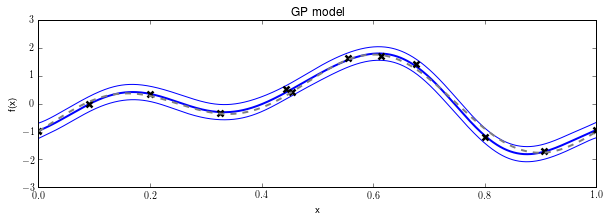

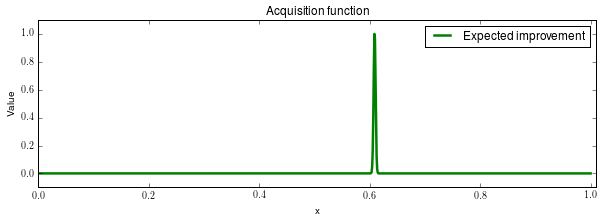

In [18]:
# 1.- Collect an new sample where the MPI indicates and attach to the previous dataset
x_new = max_EI3
y_new = -np.cos(2*np.pi*x_new) + np.sin(4*np.pi*x_new) + np.random.randn(1,1)*0.1
X = np.vstack([X,x_new])
Y = np.vstack([Y,y_new])

# 2.- Run and optimize the new GP model
k = GPy.kern.RBF(input_dim=1, variance=.1, lengthscale=.1)
m_augmented = GPy.models.GPRegression(X, Y, k)
m_augmented.constrain_positive('')
m_augmented.likelihood.fix(0.01)
m_augmented.optimize_restarts(num_restarts = 10, messages=0)

# 3.- Optimize aquisition function MPI
acqu_EI3 = EI_max(X_eval,m_augmented,0.5) 
max_EI3 = X_eval[np.argmax(acqu_EI3)]
res_max_EI3 = np.vstack([res_max_EI3,max_EI3])
x_res = np.linspace(1,res_max_EI3.shape[0],res_max_EI3.shape[0])

# GP plot
plt.rcParams['figure.figsize'] = 10, 3 
# GP plot
fest = m_augmented.predict(X_star)
plt.plot(X_star,fest[0],c='blue',lw=2,ls='-',mew=4)
plt.plot(X_star,fest[0]+1.96*np.sqrt(fest[1]),c='blue',lw=1,ls='-',mew=1)
plt.plot(X_star,fest[0]-1.96*np.sqrt(fest[1]),c='blue',lw=1,ls='-',mew=1)
plt.plot(X,Y,'kx',mew=2.5)
plt.title('GP model')
plt.xlabel('x')
plt.plot(X_star,Y_star,c='grey',lw=2,ls='--',mew=1.5)
plt.ylabel('f(x)')
plt.xlim(0,1)
plt.savefig('datamodel7.pdf')
# EI plot
plt.rcParams['figure.figsize'] = 10, 3 
plt.figure(figsize=(10,3))
p1, = plt.plot(X_eval,(acqu_EI3-min(acqu_EI3))/(max(acqu_EI3-min(acqu_EI3)) or 1.), 'g-',lw=2.5)
plt.title('Acquisition function')
plt.xlim(0,1.01)
plt.ylim(-0.1,1.1)
plt.xlabel('x')
plt.ylabel('Value')
plt.legend([p1], ["Expected improvement"])
plt.savefig('aq7.pdf')

#print m_augmented
# Convergence plot
#plt.subplot(1, 2, 2)
#plt.plot(x_res,res_max_EI3,'kx',mew=4.5)
#plt.title('Convergence to the maximum')
#plt.xlabel('iteration')
#plt.ylabel('Value')
#plt.ylim(-0.25,1.5)
#plt.plot(x_res,res_max_EI3,'g-',lw=2.5)
#axhline(y=0.6010,ls='--',c='red'#)

As you can see, after the first iterations, the aquisition function explores the domain of $f$. In some cases it is either flat or it concentrates all the mass in a point, which normally conincides with the exploration of the limit of the function domain. After some iterations, however, it becomes more narrow and the convergence to the maximum of $f$, 0.6010, is achieved. We only needed 7 data points!! 